<a href="https://colab.research.google.com/github/Wiicht/Portfolio/blob/main/Movies_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inspecting and manipulating a DataFrame with Movies 

In [16]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [11, 11]

In [3]:
from google.colab import files
df = files.upload()

Saving movies.csv to movies.csv


In [74]:
df = pd.read_csv('movies.csv')

##Let's take a look

In [75]:
df.head(3)

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0,46998772.0,Warner Bros.,146.0
1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,58853106.0,Columbia Pictures,104.0
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.0,538375067.0,Lucasfilm,124.0


##Let's inspect the dataframe

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7668 entries, 0 to 7667
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      7668 non-null   object 
 1   rating    7591 non-null   object 
 2   genre     7668 non-null   object 
 3   year      7668 non-null   int64  
 4   released  7666 non-null   object 
 5   score     7665 non-null   float64
 6   votes     7665 non-null   float64
 7   director  7668 non-null   object 
 8   writer    7665 non-null   object 
 9   star      7667 non-null   object 
 10  country   7665 non-null   object 
 11  budget    5497 non-null   float64
 12  gross     7479 non-null   float64
 13  company   7651 non-null   object 
 14  runtime   7664 non-null   float64
dtypes: float64(5), int64(1), object(9)
memory usage: 898.7+ KB


In [77]:
df.shape

(7668, 15)

In [78]:
if df.isnull().values.any() != False:
  print('There are some missing elements:')
  print(df.isna().sum())
else:
  print('No missing elements.')

There are some missing elements:
name           0
rating        77
genre          0
year           0
released       2
score          3
votes          3
director       0
writer         3
star           1
country        3
budget      2171
gross        189
company       17
runtime        4
dtype: int64


##Now we can start cleaning the dataframe

In [86]:
# Here it does not make sence to utilise more sophisticated methods (like interpolating) to fill in the NaNs. Because there is propably no relationship among them
df = df.dropna(inplace=False, axis=0) # Dropping missing elements

In [87]:
# Let's see if there are still NaNs
if all(is_zero == 0 for is_zero in [df[col].isnull().sum().sum() for col in df.columns]) == True:
  print('There are no NaNs anymore.')
else:
  print('There are still NaNs.')

There are no NaNs anymore.


In [88]:
# We do not need the votes, budget, gross and runtime to be floats. Change to int
df[['votes', 'budget', 'gross', 'runtime']] = df[['votes', 'budget', 'gross', 'runtime']].astype(int)

In [89]:
# Then we sort it by gross
df = df.sort_values(by=['gross'], ascending=False, inplace=False)
df.head(2)

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
5445,Avatar,PG-13,Action,2009,"December 18, 2009 (United States)",7.8,1100000,James Cameron,James Cameron,Sam Worthington,United States,237000000,2847246203,Twentieth Century Fox,162
7445,Avengers: Endgame,PG-13,Action,2019,"April 26, 2019 (United States)",8.4,903000,Anthony Russo,Christopher Markus,Robert Downey Jr.,United States,356000000,2797501328,Marvel Studios,181


## Lets look at the budget to gross correlation

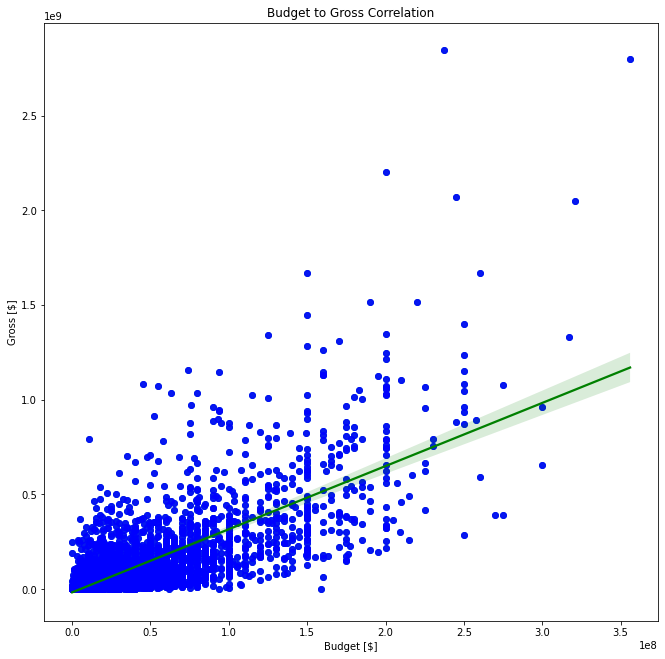

In [105]:
plt.scatter(df['budget'], df['gross'])
sns.regplot(x=df['budget'], y=df['gross'], data=df, color='red', scatter_kws={'color':'blue'}, line_kws={'color':'green'});
plt.title('Budget to Gross Correlation')
plt.xlabel('Budget [$]')
plt.ylabel('Gross [$]')
plt.show()

In [112]:
corr = df.corr(method= "pearson")
corr.style.background_gradient(cmap='coolwarm')

,year,score,votes,budget,gross,runtime
year,1.000000,0.056386,0.206021,0.327722,0.274321,0.075077
score,0.056386,1.000000,0.474256,0.072001,0.222556,0.414068
votes,0.206021,0.474256,1.000000,0.439675,0.614751,0.352303
budget,0.327722,0.072001,0.439675,1.000000,0.740247,0.318695
gross,0.274321,0.222556,0.614751,0.740247,1.000000,0.275796
runtime,0.075077,0.414068,0.352303,0.318695,0.275796,1.000000


**Conclusion:**
From the plot and the correlation matrix ($r^{2}$=0,74), we can conclude that there is a rather strong correlation between the budget and the gross.<br>
So in general: The higher the bugdet, the higher the gross.

## Now we will take a closer look at the relationship between genre and gross

In [92]:
df['genre'].value_counts()

Comedy       1496
Action       1415
Drama         863
Crime         399
Adventure     327
Biography     311
Animation     277
Horror        251
Fantasy        41
Mystery        17
Thriller        7
Sci-Fi          6
Romance         5
Family          4
Western         2
Name: genre, dtype: int64

In [93]:
df.head(2)

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
5445,Avatar,PG-13,Action,2009,"December 18, 2009 (United States)",7.8,1100000,James Cameron,James Cameron,Sam Worthington,United States,237000000,2847246203,Twentieth Century Fox,162
7445,Avengers: Endgame,PG-13,Action,2019,"April 26, 2019 (United States)",8.4,903000,Anthony Russo,Christopher Markus,Robert Downey Jr.,United States,356000000,2797501328,Marvel Studios,181


In [94]:
# For that we have to convert the genre elements of the gernes to dummy variables.
cols = list(set([x for x in df['genre']])) # we want every element only once in cols but as a list.
dummies = pd.DataFrame()
dummies[cols] = pd.get_dummies(df['genre'])
dummies.head(5)

,Horror,Western,Crime,Family,Drama,Action,Comedy,Animation,Thriller,Sci-Fi,Fantasy,Mystery,Biography,Adventure,Romance
5445,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7445,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3045,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
6663,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7244,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [100]:
result = pd.concat([df, dummies], axis=1, join='inner') # put the dataframes together
result['intercept'] = 1 # insert a Intercept
if len(cols) > 18: # to not remove more than 1 element
  print("We delete {} from the list." .format(cols[-1]))
  cols.pop(-1)
cols.append('intercept')

In [101]:
lm = sm.OLS(df['gross'], result[cols])

In [102]:
res = lm.fit()

In [103]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  gross   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     52.22
Date:                Thu, 10 Feb 2022   Prob (F-statistic):          2.07e-137
Time:                        07:19:53   Log-Likelihood:            -1.1061e+05
No. Observations:                5421   AIC:                         2.212e+05
Df Residuals:                    5406   BIC:                         2.213e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Horror      5.909e+07   1.41e+07      4.194      0.0

The $r^{2}$ value is rather low so there is a huge variance between the independent and the dependent variable.<br>
From the p-Value we find that there are significant differences for some of the genres.